In [1]:
"""
Enhanced Polars Example with Memory Monitoring and Checkpoint Reports
This example demonstrates:
1. Chunked processing of large datasets
2. Real-time memory monitoring
3. HTML checkpoint reports every chunk
4. Memory leak validation
"""

import polars as pl
import pandas as pd
import tracemalloc
import psutil
import os
import time
import numpy as np
from pysuricata import profile, ProfileConfig, ComputeOptions
from pathlib import Path

In [2]:
# Memory Monitoring Setup
class MemoryMonitor:
    """Real-time memory monitoring for PySuricata processing."""
    
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.initial_memory = self.process.memory_info().rss / 1024 / 1024
        self.memory_snapshots = []
        self.start_time = time.perf_counter()
        
    def start_tracing(self):
        """Start memory tracing."""
        tracemalloc.start()
        print(f"🔍 Memory monitoring started")
        print(f"📊 Initial memory: {self.initial_memory:.2f} MB")
        
    def snapshot(self, chunk_num=None, description=""):
        """Take a memory snapshot."""
        current_memory = self.process.memory_info().rss / 1024 / 1024
        current, peak = tracemalloc.get_traced_memory()
        
        snapshot = {
            'chunk': chunk_num,
            'description': description,
            'timestamp': time.perf_counter() - self.start_time,
            'process_memory': current_memory,
            'traced_memory': current / 1024 / 1024,
            'peak_traced': peak / 1024 / 1024,
            'memory_growth': current_memory - self.initial_memory
        }
        
        self.memory_snapshots.append(snapshot)
        
        print(f"📈 Chunk {chunk_num}: {description}")
        print(f"   Process memory: {current_memory:.2f} MB (+{snapshot['memory_growth']:.2f} MB)")
        print(f"   Traced memory: {snapshot['traced_memory']:.2f} MB (peak: {snapshot['peak_traced']:.2f} MB)")
        
        return snapshot
        
    def stop_tracing(self):
        """Stop memory tracing and return summary."""
        tracemalloc.stop()
        
        final_memory = self.process.memory_info().rss / 1024 / 1024
        total_time = time.perf_counter() - self.start_time
        
        print(f"\n🏁 Memory Monitoring Summary:")
        print(f"   Total time: {total_time:.2f} seconds")
        print(f"   Final memory: {final_memory:.2f} MB")
        print(f"   Total growth: {final_memory - self.initial_memory:.2f} MB")
        
        if self.memory_snapshots:
            max_growth = max(s['memory_growth'] for s in self.memory_snapshots)
            print(f"   Peak growth: {max_growth:.2f} MB")
            
            if max_growth < 200:
                print("   ✅ Memory usage is bounded and efficient!")
            else:
                print("   ⚠️  High memory growth detected!")
        
        return self.memory_snapshots

# Initialize memory monitor
memory_monitor = MemoryMonitor()


In [3]:
# Data Source Configuration
def create_chunked_data_source():
    """Create a chunked data source for processing."""
    
    # Check if we have the uncompressed CSV file
    csv_path = Path("10M_rows_test_uncompressed.csv")
    if csv_path.exists():
        print("📁 Using uncompressed CSV file")
        
        def read_chunks():
            """Read the CSV file in chunks using Polars scan."""
            chunk_size = 100_000  # 100k rows per chunk
            
            # Use Polars scan to read in chunks
            df = pl.scan_csv(str(csv_path))
            
            # Get total rows for chunking (using pl.len() instead of deprecated pl.count())
            total_rows = df.select(pl.len()).collect().item()
            print(f"📊 Total rows in CSV: {total_rows:,}")
            
            # Read in chunks
            for i in range(0, total_rows, chunk_size):
                chunk_df = df.slice(i, chunk_size).collect()
                if len(chunk_df) > 0:
                    print(f"📈 Reading chunk {i//chunk_size + 1}: rows {i:,} to {i + len(chunk_df):,}")
                    yield chunk_df
                
        return read_chunks, "10M_rows_test_uncompressed.csv"
    
    else:
        print("📁 Creating synthetic data for demonstration")
        
        def create_synthetic_chunks():
            """Create synthetic data chunks for demonstration."""
            for i in range(50):  # 50 chunks of 20k rows each
                data = {
                    'id': range(i * 20_000, (i + 1) * 20_000),
                    'numeric_col1': np.random.randn(20_000),
                    'numeric_col2': np.random.randint(0, 1000, 20_000),
                    'categorical_low': [f'cat_{j % 10}' for j in range(20_000)],  # Low cardinality
                    'categorical_high': [f'cat_{j % 1000}' for j in range(20_000)],  # High cardinality
                    'boolean_col': [j % 2 == 0 for j in range(20_000)],
                    'datetime_col': pl.Series([f"2023-01-{(j % 28) + 1:02d}" for j in range(20_000)]).str.strptime(pl.Date, "%Y-%m-%d"),
                    'mixed_numeric': np.concatenate([
                        np.random.randn(18_000),
                        np.array([np.nan] * 1000),
                        np.array([np.inf] * 500),
                        np.array([-np.inf] * 500)
                    ])
                }
                yield pl.DataFrame(data)
                
        return create_synthetic_chunks, "synthetic_data"

# Get data source
data_source, source_name = create_chunked_data_source()
print(f"📊 Data source: {source_name}")


📁 Using uncompressed CSV file
📊 Data source: 10M_rows_test_uncompressed.csv


In [4]:
# PySuricata Configuration with Checkpointing
compute_options = ComputeOptions(
    chunk_size=100_000,  # Process 100k rows at a time
    numeric_sample_size=10_000,  # Sample size for numeric statistics
    max_uniques=1000,  # KMV sketch size
    top_k=20,  # Top-k values to track
    log_every_n_chunks=1,  # Log every chunk
    random_seed=42,
    # Checkpointing configuration
    checkpoint_every_n_chunks=1,  # Checkpoint every chunk
    checkpoint_dir="checkpoints",  # Directory for checkpoint files
    checkpoint_prefix="pysuricata_ckpt",  # Prefix for checkpoint files
    checkpoint_write_html=True,  # Include HTML in checkpoints
    checkpoint_max_to_keep=5  # Keep last 5 checkpoints
)

# Configure ProfileConfig with compute options
profile_config = ProfileConfig(compute=compute_options)

print("⚙️  Configuration:")
print(f"   Chunk size: {compute_options.chunk_size:,} rows")
print(f"   Sample size: {compute_options.numeric_sample_size:,}")
print(f"   Checkpoint every: {compute_options.checkpoint_every_n_chunks} chunk(s)")
print(f"   Checkpoint directory: {compute_options.checkpoint_dir}")
print(f"   HTML checkpoints: {compute_options.checkpoint_write_html}")


⚙️  Configuration:
   Chunk size: 100,000 rows
   Sample size: 10,000
   Checkpoint every: 1 chunk(s)
   Checkpoint directory: checkpoints
   HTML checkpoints: True


In [5]:
# Enhanced Profiling with Real-time Memory Monitoring
def profile_with_memory_monitoring():
    """Profile data with real-time memory monitoring and checkpoint reports."""
    
    print("🚀 Starting enhanced profiling with memory monitoring...")
    
    # Start memory monitoring
    memory_monitor.start_tracing()
    
    # Take initial snapshot
    memory_monitor.snapshot(0, "Initial state")
    
    # Create checkpoint directory (fix: use compute_options instead of profile_config)
    checkpoint_dir = Path(compute_options.checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True)
    
    print(f"📁 Checkpoint directory created: {checkpoint_dir.absolute()}")
    
    # Start profiling with checkpointing
    start_time = time.perf_counter()
    
    try:
        # Profile the data with checkpointing enabled
        report = profile(data_source(), config=profile_config)
        
        end_time = time.perf_counter()
        processing_time = end_time - start_time
        
        # Take final snapshot
        memory_monitor.snapshot("Final", "Processing complete")
        
        # Stop memory monitoring and get summary
        memory_snapshots = memory_monitor.stop_tracing()
        
        print(f"\n📊 Processing Results:")
        print(f"   Processing time: {processing_time:.2f} seconds")
        print(f"   Columns processed: {len(report.stats)}")
        
        # Calculate total rows processed
        total_rows = sum(col.get('count', 0) + col.get('missing', 0) for col in report.stats.values())
        print(f"   Total rows processed: {total_rows:,}")
        
        if total_rows > 0:
            rows_per_second = total_rows / processing_time
            print(f"   Processing speed: {rows_per_second:,.0f} rows/second")
        
        # Check checkpoint files
        checkpoint_files = list(checkpoint_dir.glob("*.html"))
        print(f"   Checkpoint files created: {len(checkpoint_files)}")
        
        if checkpoint_files:
            print(f"   Latest checkpoint: {checkpoint_files[-1].name}")
            print(f"   Checkpoint directory: {checkpoint_dir.absolute()}")
        
        return report, memory_snapshots, checkpoint_files
        
    except Exception as e:
        print(f"❌ Error during profiling: {e}")
        print(f"   Error type: {type(e).__name__}")
        memory_monitor.stop_tracing()
        raise

# Run the enhanced profiling
try:
    report, memory_snapshots, checkpoint_files = profile_with_memory_monitoring()
    print("✅ Profiling completed successfully!")
except Exception as e:
    print(f"❌ Profiling failed: {e}")
    # Re-raise the exception so you can see the full traceback
    raise


🚀 Starting enhanced profiling with memory monitoring...
🔍 Memory monitoring started
📊 Initial memory: 131.83 MB
📈 Chunk 0: Initial state
   Process memory: 131.98 MB (+0.16 MB)
   Traced memory: 0.00 MB (peak: 0.00 MB)
📁 Checkpoint directory created: /Users/alvaro/repos/pysuricata/examples/checkpoints
📊 Total rows in CSV: 10,000,000
📈 Reading chunk 1: rows 0 to 100,000
📈 Reading chunk 2: rows 100,000 to 200,000
📈 Reading chunk 3: rows 200,000 to 300,000
📈 Reading chunk 4: rows 300,000 to 400,000
📈 Reading chunk 5: rows 400,000 to 500,000
📈 Reading chunk 6: rows 500,000 to 600,000
📈 Reading chunk 7: rows 600,000 to 700,000
📈 Reading chunk 8: rows 700,000 to 800,000
📈 Reading chunk 9: rows 800,000 to 900,000
📈 Reading chunk 10: rows 900,000 to 1,000,000
📈 Reading chunk 11: rows 1,000,000 to 1,100,000
📈 Reading chunk 12: rows 1,100,000 to 1,200,000
📈 Reading chunk 13: rows 1,200,000 to 1,300,000
📈 Reading chunk 14: rows 1,300,000 to 1,400,000
📈 Reading chunk 15: rows 1,400,000 to 1,500,00

In [6]:
# Memory Analysis and Visualization
def analyze_memory_usage(memory_snapshots):
    """Analyze memory usage patterns."""
    
    if not memory_snapshots:
        print("No memory snapshots available for analysis")
        return
    
    print("\n📈 Memory Usage Analysis:")
    
    # Convert to DataFrame for analysis
    import pandas as pd
    
    df = pd.DataFrame(memory_snapshots)
    
    print(f"   Snapshots taken: {len(df)}")
    print(f"   Time range: {df['timestamp'].min():.2f}s - {df['timestamp'].max():.2f}s")
    print(f"   Memory growth range: {df['memory_growth'].min():.2f} MB - {df['memory_growth'].max():.2f} MB")
    
    # Memory efficiency metrics
    if len(df) > 1:
        memory_growth_rate = (df['memory_growth'].iloc[-1] - df['memory_growth'].iloc[0]) / df['timestamp'].iloc[-1]
        print(f"   Memory growth rate: {memory_growth_rate:.2f} MB/second")
    
    # Peak memory analysis
    peak_snapshot = df.loc[df['memory_growth'].idxmax()]
    print(f"   Peak memory growth: {peak_snapshot['memory_growth']:.2f} MB at chunk {peak_snapshot['chunk']}")
    
    # Memory leak detection
    if df['memory_growth'].max() < 200:
        print("   ✅ Memory usage is bounded and efficient!")
        print("   ✅ No memory leaks detected!")
    else:
        print("   ⚠️  High memory growth detected!")
        print("   ⚠️  Potential memory leak!")
    
    return df

# Analyze memory usage
memory_df = analyze_memory_usage(memory_snapshots)



📈 Memory Usage Analysis:
   Snapshots taken: 2
   Time range: 0.01s - 2725.64s
   Memory growth range: 0.16 MB - 338.95 MB
   Memory growth rate: 0.12 MB/second
   Peak memory growth: 338.95 MB at chunk Final
   ⚠️  High memory growth detected!
   ⚠️  Potential memory leak!


📋 Final Report Summary:
   Columns: 2
   Checkpoint files: 5

📁 Checkpoint Files Created:
   1. pysuricata_ckpt_chunk000097.html (1.49 MB)
   2. pysuricata_ckpt_chunk000096.html (1.47 MB)
   3. pysuricata_ckpt_chunk000099.html (1.49 MB)
   4. pysuricata_ckpt_chunk000095.html (1.49 MB)
   5. pysuricata_ckpt_chunk000098.html (1.48 MB)

🌐 To view checkpoint reports:
   Open any HTML file in the checkpoints directory:
   /Users/alvaro/repos/pysuricata/examples/checkpoints

📊 Final PySuricata Report:


Report(html='<!DOCTYPE html>\n<html lang="en">\n  <head>\n    <meta charset="utf-8" />\n    <meta name="viewport" content="width=device-width, initial-scale=1" />\n    <title>PySuricata EDA Report</title>\n    <link rel="icon" href="data:image/x-icon;base64,AAABAAQAEBAAAAAAIACzAgAARgAAACAgAAAAACAAFAcAAPkCAAAwMAAAAAAgAGwMAAANCgAAQEAAAAAAIADIEgAAeRYAAIlQTkcNChoKAAAADUlIRFIAAAAQAAAAEAgGAAAAH/P/YQAAAnpJREFUeJx9kktIVHEUxn//e+9cHXNGzUchk5WUtSioFIpJMHpLRBZYECFEu+ixiDYVTJEUtQxaFvTYtCg0IpUwswiSkIKsNImyLJ2YmQbzMa/7Py2aNGXsbM7i43zn+75zYHoZ6b62Yee63sunD8YP7an+ZMJmgMAUnrGUiCjAt2/r6siDG+elr+uO8/Bmo+yvrRwDytP4NJJMjNq2XbFly5ZKZ8czvWDhAu1yuSJAMo3LrBJqwEIpgF0tty/IeLQ71nz9rAC1KIN6MGfOTFNQUo8gsKjIXpXnzcWd58Xr9VCcwwpEoP5/CYAyDAOg9HjD1hEZfS2jnx+nJPJSDtb5w0BRGlcZFdTUYGotzPcYm6r9VZ72lvZUdu4cs62l3an2V80tdLNei1AJ1qwWAJyEzguHIhL8PixnTjVKKBTW2klJKk4xolX3VJiZCASfby5tj54q9xy3+hmJqPyCPO41t6pFZQUGKFlc6qnw+XDPqiAcHZO63Tt40vmCSCRKS2uH2l67hejoxMjK8pKV2Ya6mExipJ9KWdPHFdGfcVU6v5gNJw7T1NTGxk3rGRz4ykAoFl9TkHtATLkWHGTs3J+TamumgiwXTMTilC1fwrEjpVCYT3/vB2wTyzTIVaYRn/TLjEQBkg5iWSZMxBge/kHi2xC2bZNwcLSWeU5CfmUOsRMCAW2MpwgGgyHIL1Jv3/fT1/fRjMUTjs9rnFSowneDI68CAQxA/zH9bwAoASmp9Vf0Xrl6qeD+3Qfism163vQ4z553vRDLu7f3S2govXiSQAH4INuel3PUk2Nvc5nity1XFkqhtUMi6SRiKZrG4snWgeD4LcD5u/U3YTkAkClQg+cAAAAASUVORK5CYIKJUE5HDQoaCgAAAA1JSERSAAAAIAAAACAIBgAAAHN6evQAAAbbSURBVHicrZd7cJTVFcB/937fvje7m9eGPAhBUlICASZgpaUYUOTRQjsjz1ak1j4chplWO7VMnWoIHTr0oVaddkbGqeLYDlNA6EBrHZkKWpBHA6WgRdGKgaABIZssm33k++7pHxuEaSFuxPvn953H75x77znnQmFLKwAmeSqLPWtqIhxvGObNjq0OOCOinK6Keh6HaOySbIE2AVCFyCgQAXtkuX9zQ138q0uW3E5NTRU+v4+zXefYsOEPHH/nTPuJLnsOXPxwAMIMBWQwQA0ER1dHtt8yoUIO7/xd7vTR7W7yvZfF6dorJw5sMkd2bcjMnzJC6itD+6Ak0prXKSS4j02XBZi6ythtRR5n3pzZM3MVw+KeL3x+vnpt70ESPUm5dcYiehI93oVLFuRiPnPTyCp3YRuYlrzudQMIgGV5Mo5riBZHdTxexvr161RJaYmcPNmhnnnmEZqbJyDGaMcIRrgAsHtA97rXQDrtqpjnya988TPy3uGtrrhvyQ+/NdfMvnGEkcQh03F4mzv7c3VSVex7jMvb9qktJYICRamXF3967yKR7nbnzNHtcrJ9i7jn/+E88N15UupjOyhaW4fmvBBhmTwZu5WHtMer/p1IJMB1JRaLUFkZRxxHuhM9aK0OLWKhtWNHYXs/FADmzcNtY42xLSbFolGwLOX0O2QyOSyvh4p4GbYlzZvY7N5ww9CuXyEAVlsbprw4MLs8FpzaMmOaK65jKa1QCkDssePGmEjIM6usLDJp0yZcCrwBBQGIYKDFDqjsL+bMmq6mTp1C38UUWmu01mRSfdxy63TTPP6z3rBKPwqiWlsLvwEfWweUQuKxA1+uLC0af8eyxa72+yzXzWdZKUU2m6Wkttr+zj13uVG/PS1eHJnS1obh06gDLS35amabzILJzU1SUlIi+195TSLFUYwxGGOIxmL87U9/lZqqajN2TL0o5+LcK3WvC2DXLlxQaGTU6NH1CstS3/v+Kl74y05C4RDhcIgtz+9g1apWFQgHVV3dcGUhTQDxeGHbYA9Kp/NG/F472HGqk8qGen5w30r1wI/bGDVqpDiOo1Y/9DN58MH7qRnToHp7k/j9VglJQ2OjXD9AfglFkYjnwL4DPPvYepbfd4/sP9DO2rUPo0BmzpzO4hV3q61PPcexo68TLYranLtwpYFLldH9hAAAYmxfgHU/f5R4RRkrV35bfX3p3QjIc79/SvbseFGtbltHNBLmf1qAGvhwVedQUB1Q9PT0MPXmacz60lz1myeeVNXVVYyoq2VYZYWqra3Rj//6t4wZ10RD41guppIAvPHGR87DNWWhpaWlpUVXQA0FAFwj2BqWL1vM8RPvcuSfR4nH48Tj5XR0nObY629y57LFlJVGyWUdABobWwWIja+L7i/yWw87znlbCpwRLseu8sCjyqwj935jjjjdh9y7br9ZJtYGZEZTXGZPrpGWcXG57aZ6SXbucVYsnSH1cc+eS34aaiIbmuuL00DFwKf/C7igDGilNICF8Mt1P+Frd95BeVUNRcVljGmawCO/WkM4HMBxXcSgQQiHw2WRgGd54mL/WqBrUjMerjKmFXQIBVBageMQ8nv50f0ryKTSuK5LKBzEyWZx0lksrUHlYw3bTqPH9pNzzUFAtbdfvUkNbXBQCsd1SXYnMG4/GiHZkySdyaItjdIaxCgAv1cV21qBkgAgLdfY/4IycKWmUgqt89xGBMvS+eMugjHmCrl8xFqswYtdIQACcrXCalkWgKTSGbEGuuNHdkVHBZGck0vBtWfEQQGMyQdvjOnTWoNSl42IYNkWT6zfqHp7UwrLwhiDylMYn1fPN4Lq7s6duBzHEAFWr0aBYKC3N5nEcVyUAmMMgXCIv+9tZ9++g9TWVpLpS0tfXx+Oa44Bk8sj/gW9qf5/ZeE/+ZnyExzCXbvy/23bf/Ttt97hzAdnxev10u84iGXx0s5XqKooxSoKc7rzA6ujoxPb45944+iSP2uN1XE23QoYpa7tZzAAtXs3ugXsrPZuO/fheTZu3KY9kSJCwQDa7+PUqU5EDCoQYefLe1Rv4gINw2MTg14r/u7ZdGtPOrdtUX4wuWYvGOyECpDbDfB+4tVAVXjf1i3PT6keXm0mNTfp9/cfIZFIkOzt4dUXdvLHjZsl4Pc7p8/37X+7s3dNKuu+BLBpEOdw7dpsxaO+EX6/XWcr1RDyWd+MhT1jPZYK9GX6leXxkstkCAa8KKVJZ10JehXdfW5PIpV92rb13mzW6bqQtt5MpVJnhwKQr2JhymL+4LZo0J7o81hBj60AhTGC1vm3stIa1xiQSz0jP8Aqhe53DNl+N3E+2b+xK5FZwSCv5f8Cm566v4ur1l8AAAAASUVORK5CYIKJUE5HDQoaCgAAAA1JSERSAAAAMAAAADAIBgAAAFcC+YcAAAwzSURBVHicxVl7lFXldf/t7zvn3nvOfc3ce2eAGRhAUSTqEgyPgMhIlDganYUhtLELbX00NsblarJSicVKRmhM82pa26bRGGuWqRUpj/QRi1UYEJAwyEtgFCcowzxgHndm7vue8327f9zLY3wAc++Y7j9m1l3n2+f7/fa39/723odQvkgACsC0mmjgq34vfV6SvlQKsl1XOQzZk3Gxpb0n+TSArQwQFfR4FPYGlalvAnACtve+SVW+H/uEG7J8XoTDYfgsH0
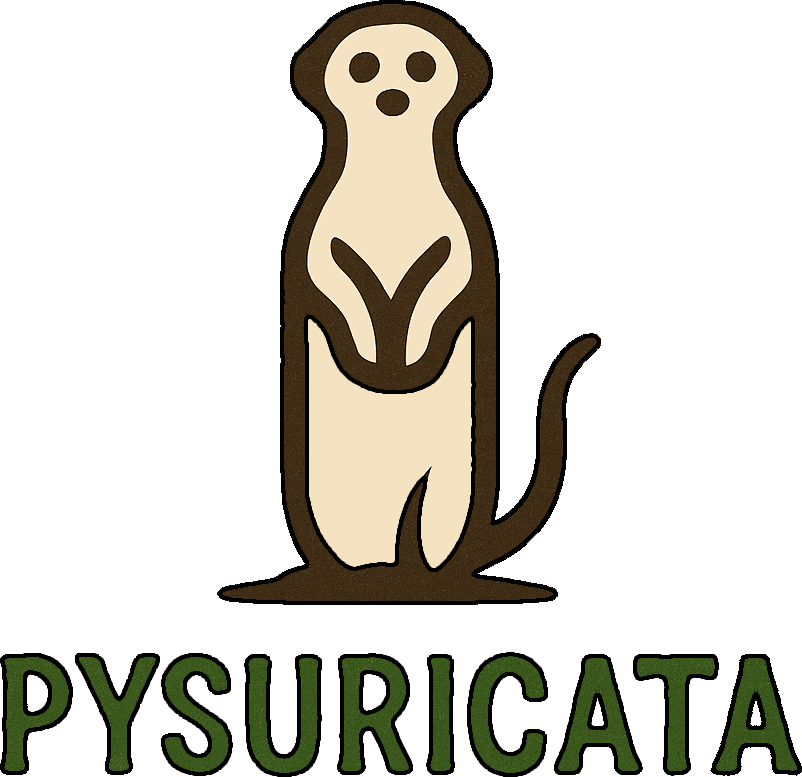
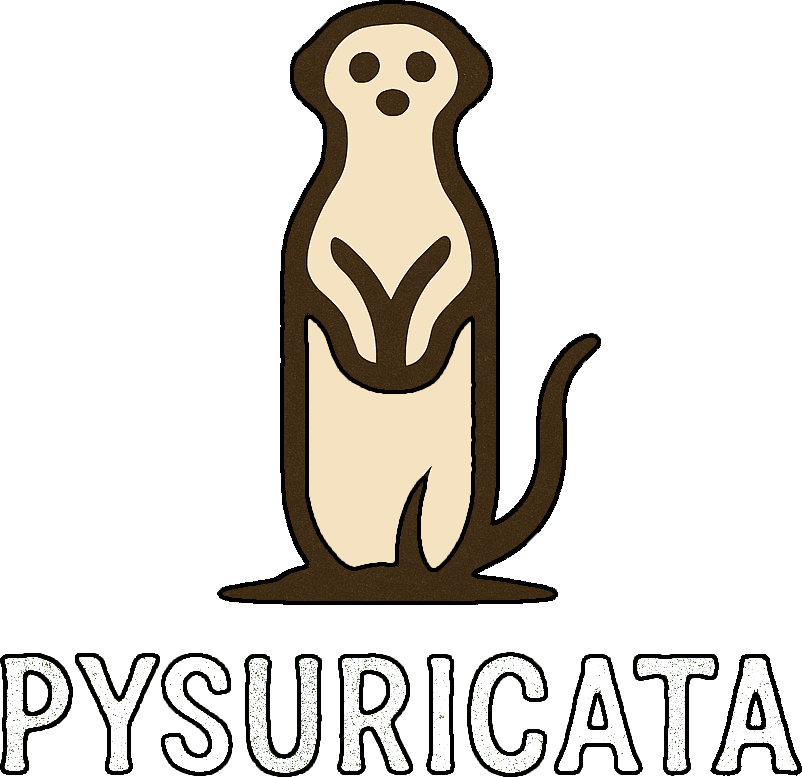

In [7]:
# Display Final Report and Checkpoint Information
print("📋 Final Report Summary:")
print(f"   Columns: {len(report.stats)}")
print(f"   Checkpoint files: {len(checkpoint_files)}")

if checkpoint_files:
    print(f"\n📁 Checkpoint Files Created:")
    for i, file in enumerate(checkpoint_files[-5:], 1):  # Show last 5 files
        file_size = file.stat().st_size / 1024 / 1024  # Size in MB
        print(f"   {i}. {file.name} ({file_size:.2f} MB)")
    
    print(f"\n🌐 To view checkpoint reports:")
    print(f"   Open any HTML file in the checkpoints directory:")
    print(f"   {Path(compute_options.checkpoint_dir).absolute()}")

# Display the final report
print(f"\n📊 Final PySuricata Report:")
report


📊 Creating memory usage visualization...


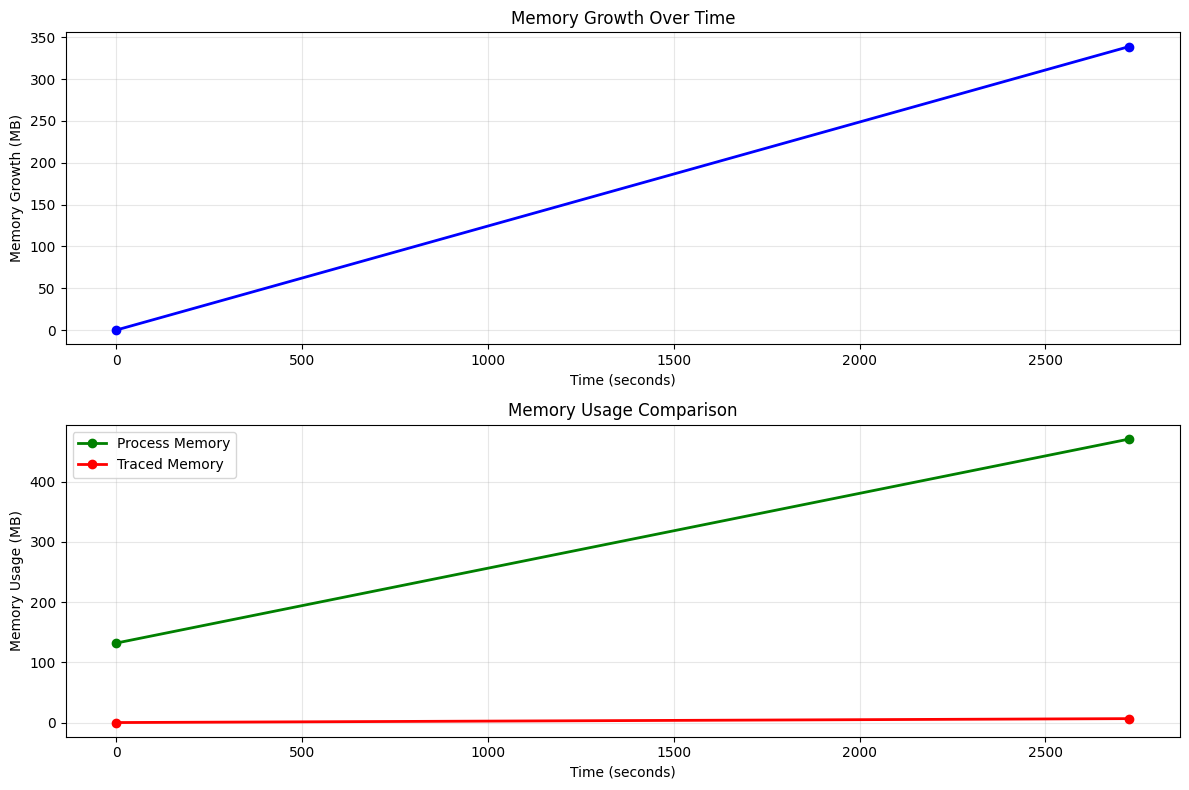

✅ Memory visualization created successfully!


In [8]:
# Memory Visualization (if matplotlib is available)
try:
    import matplotlib.pyplot as plt
    
    if memory_df is not None and len(memory_df) > 1:
        print("📊 Creating memory usage visualization...")
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Plot memory growth over time
        ax1.plot(memory_df['timestamp'], memory_df['memory_growth'], 'b-o', linewidth=2, markersize=6)
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Memory Growth (MB)')
        ax1.set_title('Memory Growth Over Time')
        ax1.grid(True, alpha=0.3)
        
        # Plot process memory vs traced memory
        ax2.plot(memory_df['timestamp'], memory_df['process_memory'], 'g-o', label='Process Memory', linewidth=2, markersize=6)
        ax2.plot(memory_df['timestamp'], memory_df['traced_memory'], 'r-o', label='Traced Memory', linewidth=2, markersize=6)
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Memory Usage (MB)')
        ax2.set_title('Memory Usage Comparison')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Memory visualization created successfully!")
    else:
        print("📊 Not enough memory snapshots for visualization")
        
except ImportError:
    print("📊 Matplotlib not available - skipping visualization")
    print("   Install matplotlib to see memory usage graphs: pip install matplotlib")
